## **Школа глубокого обучения ФПМИ МФТИ**
## **Домашнее задание. Generative adversarial networks**

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from torchsummary import summary
import cv2
from tqdm.notebook import tqdm
from torch.cuda import is_available
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q -o /content/gdrive/My\ Drive/128x128.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

In [ ]:
!ls

gdrive	images	sample_data


In [ ]:
DATA_DIR = './images/'

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  transform = tt.Compose([tt.Resize(image_size),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  dataset = ImageFolder(DATA_DIR, transform)
  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

In [ ]:
image_size = 64
batch_size = 64

#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
len(dataloader.dataset)

52001

In [ ]:
dataloader.dataset[0][0].shape

torch.Size([3, 64, 64])

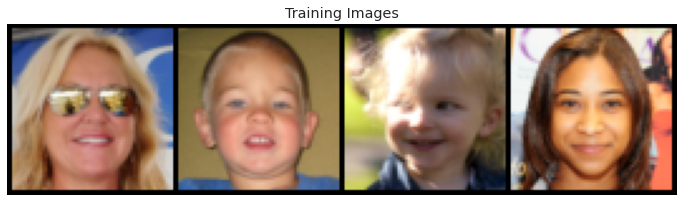

In [ ]:
batch, _ = next(iter(dataloader))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(batch[0:4].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*8, 1, kernel_size=4, stride=2, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator.to(device)
summary(discriminator, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [ ]:
latent_size = 256 # choose latent size

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, image_size*16, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(image_size*16),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*16, image_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
).to(device)

In [ ]:
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 2, 2]       4,194,304
       BatchNorm2d-2           [-1, 1024, 2, 2]           2,048
         LeakyReLU-3           [-1, 1024, 2, 2]               0
   ConvTranspose2d-4            [-1, 512, 4, 4]       8,388,608
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
         LeakyReLU-6            [-1, 512, 4, 4]               0
   ConvTranspose2d-7            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
  ConvTranspose2d-10          [-1, 128, 16, 16]         524,288
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        LeakyReLU-12          [-1, 128, 16, 16]               0
  ConvTranspose2d-13           [-1, 64, 32, 32]         131,072
      BatchNorm2d-14           [-1, 64,

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
# инициализация весов
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
lr = 0.0005

discriminator.apply(weights_init)
generator.apply(weights_init)

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].to(device)
    model["generator"].to(device)
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):


        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            # Обучение дискриминатора
            real_images = real_images.to(device)
            optimizer["discriminator"].zero_grad()

            # Передаем реальные изображения дискриминатору
            real_preds = model["discriminator"](real_images)
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Генерируем изображений
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Передаем сгенерированные изображения дискриминатору
            fake_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.0, 0.05).to(device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Обучаем генератор
            optimizer["generator"].zero_grad()

            # Генерируем изображения
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Передаем сгенерированные изображения дискриминатору
            preds = model["discriminator"](fake_images)
            targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            loss_g = criterion["generator"](preds, targets)

            # Обновляем веса
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Запись в историю
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Логирование
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Пример генерации
        plt.figure(figsize=(12,12))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, 40, lr)

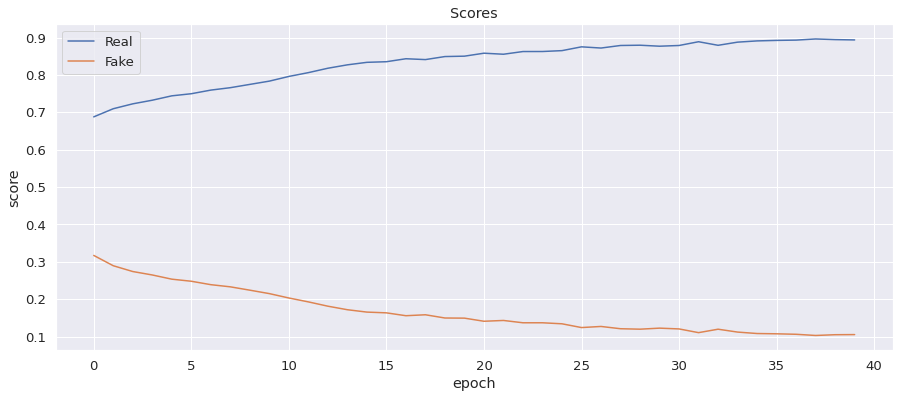

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

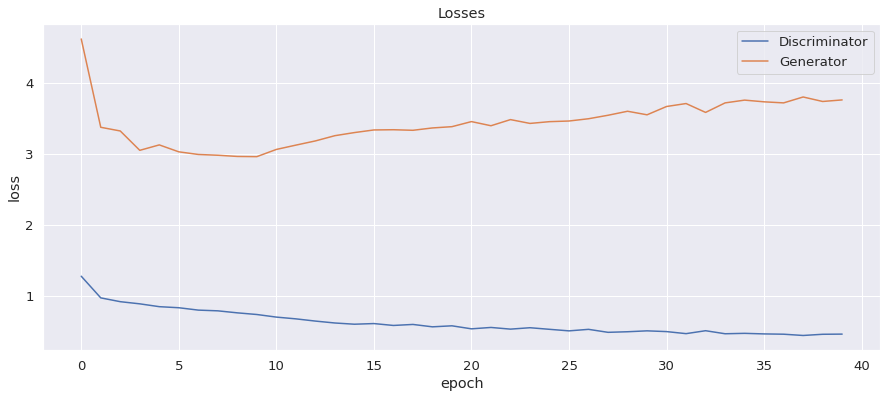

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.grid

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
def show_images(generated):
    # TODO: show generated images
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(make_grid(generated.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

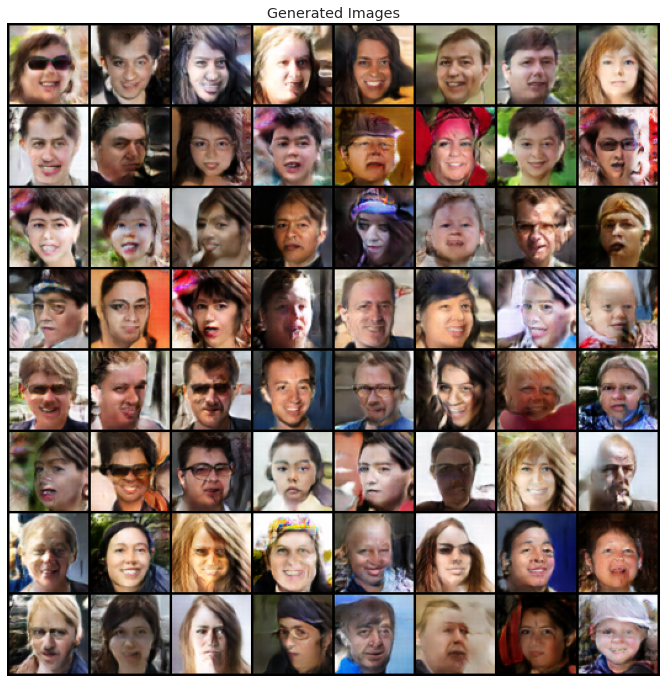

In [ ]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
n_images = 1000

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"].to(device)(fixed_latent)
real_images = next(iter(get_dataloader(64, n_images)))[0]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

zeros = torch.zeros(n_images, 1, device='cpu')
ones = torch.ones(n_images, 1, device='cpu')

X = torch.cat((fake_images.cpu(), real_images.cpu())).detach().numpy().reshape(-1, 3*64*64)
y = torch.cat((zeros, ones)).detach().numpy()

knc = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

accuracy_score_history = []
predictions = []
targets = []
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knc.fit(X_train, np.ravel(y_train))
    pred = knc.predict(X_test)
    accuracy_score_history.append(accuracy_score(pred, y_test))
    predictions.append(pred)
    targets.append(y_test)

0it [00:00, ?it/s]

In [ ]:
X.shape

(2000, 12288)

Mean accuracy = 0.689


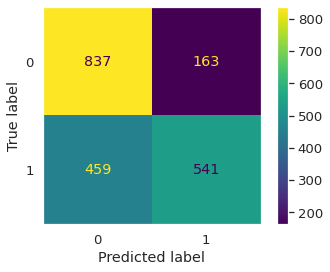

In [ ]:
print('Mean accuracy =', np.mean(accuracy_score_history))

cm =  confusion_matrix([t.item() for t in targets],
                       [p.item() for p in predictions])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

- Accuracy = 0.689 отличаестя от желаемого результата (0.5), хотя позволяет уже более-менее значимой части фейковых фоток (163 из 1000) обмануть классификатор.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

In [ ]:
x1, x2 = zip(*X_embedded)

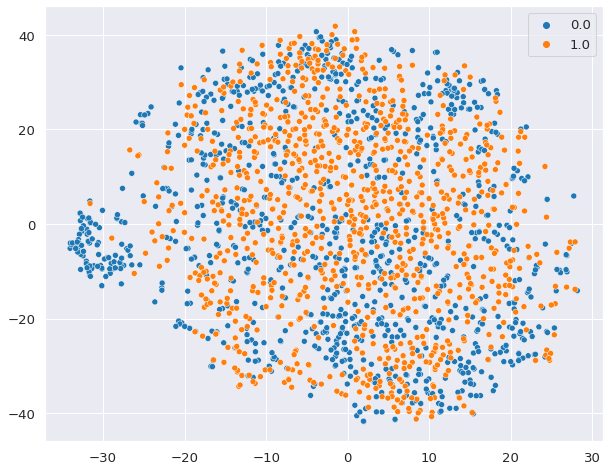

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x=x1, y=x2, hue=y.ravel(), palette='tab10', ax=ax)

Прокомментируйте получившийся результат:

- Распределения лежат в одной и той же области. Однако для настоящих фоток (1) характерно более равномерное концетрирование по области, а для фэйковых (0) - более кучное с образование небольших кластеров в некоторых местах.